In [3]:
from collections import Counter 
import itertools
q = 2
R.<z> = LaurentPolynomialRing(ZZ)

def create_symmetric_polynomial(n):
    if n < 0:
            # For negative n, we use the same pattern
        n = abs(n)       
    # Build the symmetric polynomial
    poly = R.zero()
    power = n     
    while power >= -n:
        poly += z^power
        power -= 2
    return poly

def decompose_list(poly):
    temp = poly
    result = []
    while not temp == 0:
        deg = temp.degree()
        result.append(deg)
        temp -= create_symmetric_polynomial(deg)
    return list(Counter(result).items())



# The Hopf algebra quantum sl2
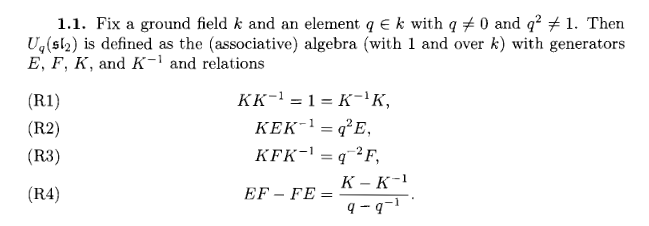


We implement a class of U_q(sl2)-modules which supports tensor products

In [4]:

# we define the algebra U_q(sl2) as the quotient of a free algebra over the complex numbers
#F.<e,f,k,kinv> = FreeAlgebra(CC, 4)
#relations = [k*kinv - 1, kinv*k - 1, k*e*kinv - q^2*e, k*f*kinv - q^(-2)*f, e*f-f*e - (k-kinv)/(q-q^(-1))]
#U = F.quotient(relations)


class Urep:
    def __init__(self,dimension,E,F,K):
        self.dimension = dimension
        self.space = QQbar^dimension  # Vector space over complex numbers
        if E.nrows() != self.dimension or E.ncols() != self.dimension:
            raise ValueError(f"E must be {self.dimension}x{self.dimension}")
        if F.nrows() != self.dimension or F.ncols() != self.dimension:
            raise ValueError(f"F must be {self.dimension}x{self.dimension}")
        if K.nrows() != self.dimension or K.ncols() != self.dimension:
            raise ValueError(f"K must be {self.dimension}x{self.dimension}") 
        if not (K.is_invertible()):
            raise ValueError("K is not invertible")
        # check the relations
        if not ((K*E*K.inverse() - q^2*E).is_zero() and (K*F*K.inverse() - q^(-2)*F).is_zero() and (E*F-F*E - (K-K.inverse())/(q-q^(-1))).is_zero()):
            print(E)
            print(F)
            print(K)
            print("--")
            print((K*E*K.inverse() - q^2*E))
            print(K*F*K.inverse() - q^(-2)*F)
            print(E*F-F*E - (K-K.inverse())/(q-q^(-1)))
            raise ValueError("The relations do not hold!")
        self.E = E
        self.F = F
        self.K = K
        
    def E_mult(self, vector):
        return self.E * vector
    def F_mult(self, vector):
        return self.F * vector
    def K_mult(self, vector):
        return self.K * vector
    def Kinv_mult(self, vector):
        return (self.K).inverse() * vector
        
    def basis_element(self, i):
        v = vector(QQ, [0]*self.dimension)
        v[i] = 1
        return v
    def print_matrices(self):
        print("This is a U-rep of dimension " + self.dimension.str() + ". E,F,K act by ")
        print("E:")
        print(self.E)
        print("F:")
        print(self.F)
        print("K:")
        print(self.K)
    def weights(self):
        # outputs weights with multiplicities
        char_poly = self.K.characteristic_polynomial()
        eigenvals_with_mult = char_poly.roots(QQbar, multiplicities=True)
        return eigenvals_with_mult
    def char_pos(self):
        # only makes sense if q not root of unity
        chi_pos = R.zero()
        for ev in self.weights():
            for n in range(-self.dimension, self.dimension+1):
                if (ev[0] == q^n):
                    chi_pos += ev[1] * z^n
        return chi_pos  
    def char_neg(self):
        # only makes sense if q not root of unity
        chi_neg = R.zero()
        for ev in self.weights():
            for n in range(-self.dimension, self.dimension+1):
                if (ev[0] == -q^n):
                    chi_neg += ev[1] * z^n
        return chi_neg
    def decompose_into_irreducibles(self):
        # only makes sense if q not root of unity
        decomp_pos = decompose_list(self.char_pos())
        decomp_neg = decompose_list(self.char_neg())
        result = ""
        for (i,j) in decomp_pos:
            j = str(j)
            i = str(i)
            result += "L(" + i + ",+)^"+ j + " + "
        for (i,j) in decomp_neg:
            result += "L(" + i + ",-)^"+ j + " + "
        return result[0:-2]
                    
def tensor_maps_of_Ureps(space1, space2):
    
    n1, n2 = space1.dimension, space2.dimension
    tensor_dimension = n1 * n2
    
    # Create basis labels for tensor product: (i,j) means e_i ⊗ f_j
    tensor_basis_labels = [(i, j) for i in range(n1) for j in range(n2)]
    
    # Initialize the matrices for E,F,K acting on the tensor product
    tensor_map_E = matrix(QQbar, tensor_dimension, tensor_dimension)
    tensor_map_F = matrix(QQbar, tensor_dimension, tensor_dimension)
    tensor_map_K = matrix(QQbar, tensor_dimension, tensor_dimension)

    #compute the actions of each E,F,K on the tensor basis
    
    # For each basis element e_i ⊗ f_j of the tensor product
    for col_idx, (i, j) in enumerate(tensor_basis_labels):
        # precompute all necessary actions on the base spaces
        E_ei = space1.E_mult(space1.basis_element(i))
        E_fj = space2.E_mult(space2.basis_element(j))
        F_ei = space1.F_mult(space1.basis_element(i))
        F_fj = space2.F_mult(space2.basis_element(j))
        K_ei = space1.K_mult(space1.basis_element(i))
        K_fj = space2.K_mult(space2.basis_element(j))
        Kinv_ei = space1.Kinv_mult(space1.basis_element(i))
        Kinv_fj = space2.Kinv_mult(space2.basis_element(j))
        # Compute K(e_i ⊗ f_j) = K(e_i) ⊗ K(f_j)
        for k in range(n1):
            for l in range(n2):
                if K_ei[k] != 0 and K_fj[l] != 0:
                    row_idx = tensor_basis_labels.index((k, l))
                    tensor_map_K[row_idx, col_idx] += K_ei[k] * K_fj[l]
        # Compute F(e_i ⊗ f_j) = F(e_i) ⊗ Kinv(f_j) + e_i ⊗ F(f_j)
        # first term
        for k in range(n1):
            for l in range(n2):
                if F_ei[k] != 0 and Kinv_fj[l] != 0:
                    row_idx = tensor_basis_labels.index((k, l))
                    tensor_map_F[row_idx, col_idx] += F_ei[k] * Kinv_fj[l]
        # second term
        for l in range(n2):
            if F_fj[l] != 0:
                row_idx = tensor_basis_labels.index((i, l))
                # print(i,j,col_idx,k,l)
                tensor_map_F[row_idx, col_idx] += F_fj[l]
        # Compute E(e_i ⊗ f_j) = K(e_i) ⊗ E(f_j) + E(e_i) ⊗ 1(f_j)
        # first term
        for k in range(n1):
            for l in range(n2):
                if K_ei[k] != 0 and E_fj[l] != 0:
                    row_idx = tensor_basis_labels.index((k, l))
                    tensor_map_E[row_idx, col_idx] += K_ei[k] * E_fj[l]
        # second term
        for k in range(n1):
            if E_ei[k] != 0:
                row_idx = tensor_basis_labels.index((k,j))
                tensor_map_E[row_idx, col_idx] += E_ei[k]        

    return tensor_map_E, tensor_map_F, tensor_map_K

def tensor_product_of_Ureps(space1, space2):
    n1, n2 = space1.dimension, space2.dimension
    tensor_dimension = n1 * n2
    tensor_map_E, tensor_map_F, tensor_map_K = tensor_maps_of_Ureps(space1,space2)
    result = Urep(tensor_dimension, tensor_map_E, tensor_map_F, tensor_map_K)
    return result

An object of this class can also compute its own characters and weights, and thus deduce its decomposition into irreducibles.
We would like to check if the formulas from the theory are true! And see in what way the subrepresentations lie within the tensor vector space.

First let's do a sanity check, and see if the trivial representation is a representation, and behaves how it should.

In [5]:
Etriv = matrix(QQbar,1,1,0)
Ftriv = matrix(QQbar,1,1,0)
Ktriv = matrix(QQbar,1,1,0)
Ktriv[0,0] = 1
trivial_Urep = Urep(1,Etriv,Ftriv,Ktriv)
print("TRIVIAL REP:")
trivial_Urep.print_matrices()
rep = tensor_product_of_Ureps(trivial_Urep, trivial_Urep)
print("TRIVIAL REP TENSOR TRIVIAL REP:")
rep.print_matrices()

TRIVIAL REP:
This is a U-rep of dimension 1. E,F,K act by 
E:
[0]
F:
[0]
K:
[1]
TRIVIAL REP TENSOR TRIVIAL REP:
This is a U-rep of dimension 1. E,F,K act by 
E:
[0]
F:
[0]
K:
[1]


**Next, let's define the known irreducible representations and confirm that they exist.**

In [6]:
def matrix_E(n):
    E = matrix(QQbar,n+1,n+1,0)  
    # Fill the superdiagonal with α values
    for r in range(1, n+1):
        alpha_r = (q^r - q^(-r))/(q - q^(-1))^2 * (q^(n-r+1) - q^(-n+r-1))
        E[r-1, r] = alpha_r    
    return E

def matrix_F(n):
    F = matrix(QQbar,n+1,n+1,0)    
    # Fill the subdiagonal with 1's
    for i in range(1, n+1):
        F[i, i-1] = 1   
    return F

def matrix_K(n):
    K = matrix(QQbar,n+1,n+1,0)
    # Fill the superdiagonal with powers of q
    for i in range(n+1):
        K[i, i] = q^(n - 2*i)
    return K
    
def Lplus(n):
    return Urep(n+1,matrix_E(n),matrix_F(n),matrix_K(n))
def Lminus(n):
    return Urep(n+1,-matrix_E(n),matrix_F(n),-matrix_K(n))
rep1 = Lplus(4)
rep1.print_matrices()
rep2 = Lplus(1)
rep2.print_matrices()

This is a U-rep of dimension 5. E,F,K act by 
E:
[    0  85/8     0     0     0]
[    0     0 105/8     0     0]
[    0     0     0 105/8     0]
[    0     0     0     0  85/8]
[    0     0     0     0     0]
F:
[0 0 0 0 0]
[1 0 0 0 0]
[0 1 0 0 0]
[0 0 1 0 0]
[0 0 0 1 0]
K:
[  16    0    0    0    0]
[   0    4    0    0    0]
[   0    0    1    0    0]
[   0    0    0  1/4    0]
[   0    0    0    0 1/16]
This is a U-rep of dimension 2. E,F,K act by 
E:
[0 1]
[0 0]
F:
[0 0]
[1 0]
K:
[  2   0]
[  0 1/2]


**But are they actually irreducible? To test this, we devise two methods of checking whether or not a representation is irreducible.**

In [7]:
def commutant_dimension(generators):
    """
    Compute dimension of commutant algebra.
    If dim = 1, representation is irreducible (by Schur's lemma)
    """
    n = generators[0].nrows()
    field = generators[0].base_ring()
    
    # Set up system of equations AX = XA for all generators A
    from sage.modules.free_module import VectorSpace
    equations = []
    
    for A in generators:
        # For each entry (i,j) of the equation AX = XA
        for i in range(n):
            for j in range(n):
                eq = [0] * (n*n)
                # Coefficient of X[k,l] in (AX)[i,j]
                for k in range(n):
                    # X[k,j] corresponds to index k*n + j in our vectorization
                    eq[k * n + j] += A[i, k]
                
                # Coefficients for sum_k X[i,k] * A[k,j] (subtract since we move to LHS)
                for k in range(n):
                    # X[i,k] corresponds to index i*n + k in our vectorization  
                    eq[i * n + k] -= A[k, j]
                equations.append(eq)
    
    # Solve the homogeneous system
    M = matrix(field, equations)
    kernel_dim = M.right_kernel().dimension()
    return kernel_dim

print("Is the representation L(4,+) irreducible?")
generators = [rep1.E,rep1.F,rep1.K]
dim = commutant_dimension(generators)
print(f"Commutant dimension: {dim}")
print(f"Irreducible: {dim == 1}")

Is the representation L(4,+) irreducible?
Commutant dimension: 1
Irreducible: True


__This method is lacking for two reasons.__
* It does not tell you what the subrepresentation is if in case it is reducible
* It fails completely for non-semisimple representations!

__We will fix this with a more sophisticated approach in the future.__

In [8]:
rep = tensor_product_of_Ureps(rep1,rep2)
rep.print_matrices()
print("Is the representation L(4,+) tensor L(1,+) irreducible?")
generators = [rep.E,rep.F,rep.K]
dim = commutant_dimension(generators)
print(f"Commutant dimension: {dim}")
print(f"Irreducible: {dim == 1}")


This is a U-rep of dimension 10. E,F,K act by 
E:
[    0    16  85/8     0     0     0     0     0     0     0]
[    0     0     0  85/8     0     0     0     0     0     0]
[    0     0     0     4 105/8     0     0     0     0     0]
[    0     0     0     0     0 105/8     0     0     0     0]
[    0     0     0     0     0     1 105/8     0     0     0]
[    0     0     0     0     0     0     0 105/8     0     0]
[    0     0     0     0     0     0     0   1/4  85/8     0]
[    0     0     0     0     0     0     0     0     0  85/8]
[    0     0     0     0     0     0     0     0     0  1/16]
[    0     0     0     0     0     0     0     0     0     0]
F:
[  0   0   0   0   0   0   0   0   0   0]
[  1   0   0   0   0   0   0   0   0   0]
[1/2   0   0   0   0   0   0   0   0   0]
[  0   2   1   0   0   0   0   0   0   0]
[  0   0 1/2   0   0   0   0   0   0   0]
[  0   0   0   2   1   0   0   0   0   0]
[  0   0   0   0 1/2   0   0   0   0   0]
[  0   0   0   0   0   2   1   0 

**Using the character approach, it is easy to find its decomposition into irreducibles.**

In [9]:
print("The positive character:")
print(rep.char_pos())
print("The negative character:")
print(rep.char_neg())
print("Decomposing into Laurent series gives")
print(rep.decompose_into_irreducibles())

The positive character:
z^-5 + 2*z^-3 + 2*z^-1 + 2*z + 2*z^3 + z^5
The negative character:
0
Decomposing into Laurent series gives
L(5,+)^1 + L(3,+)^1 


But how can we get a hold of the actual subrepresentations?

In [10]:
def find_all_invariant_subspaces_single(A):
    """
    Find invariant subspaces of a complex-valued matrix A.
    
    Uses the Jordan canonical form: each Jordan block of size k contributes
    exactly k invariant subspaces, and all invariant subspaces are direct
    sums of subsets of these basic invariant subspaces.

    """

    # Compute Jordan canonical form
    J, P = A.jordan_form(transformation=True)
    
    #print("Jordan form J:")
    #print(J)
    #print("\nTransformation matrix P (columns are generalized eigenvectors):")
    #print(P)
    
    # Find Jordan blocks
    jordan_blocks = find_jordan_blocks(J)

    # Find basic invariant subspaces from each Jordan block
    basic_invariant_subspaces = []
    
    for eigenval, block_size, start_idx in jordan_blocks:
   #     print(f"\nProcessing Jordan block with eigenvalue {eigenval}, size {block_size}")
        
        # Each Jordan block of size k gives k invariant subspaces
        for dim in range(1, block_size + 1):
            # Take the first dim generalized eigenvectors from this block
            basis_vectors = []
            for j in range(dim):
                col_idx = start_idx + j
                generalized_eigenvector = P.column(col_idx)
                basis_vectors.append(generalized_eigenvector)
            
            basic_invariant_subspaces.append(basis_vectors)
   #         print(f"  Invariant subspace of dimension {dim}: spanned by columns {start_idx} to {start_idx + dim - 1}")
    
    #print(f"\nFound {len(basic_invariant_subspaces)} basic invariant subspaces")
    
    # Generate all invariant subspaces as direct sums of subsets
    all_invariant_subspaces = generate_all_direct_sums(basic_invariant_subspaces)
    
    # Add the zero subspace
    all_invariant_subspaces.insert(0, [])
    
    # Sort by dimension
    all_invariant_subspaces.sort(key=lambda x: len(x))
    
    #print(f"\nTotal invariant subspaces found: {len(all_invariant_subspaces)}")
    return all_invariant_subspaces

def find_jordan_blocks(J):
    """
    Find the Jordan blocks in a Jordan canonical form matrix J.
    
    Returns:
        List of tuples (eigenvalue, block_size, start_index)
    """
    n = J.nrows()
    blocks = []
    i = 0
    
    while i < n:
        eigenval = J[i, i]
        block_size = 1
        
        # Find the size of this Jordan block
        while (i + block_size < n and 
               J[i + block_size, i + block_size] == eigenval and
               (i + block_size - 1 < n - 1 and J[i + block_size - 1, i + block_size] == 1)):
            block_size += 1
        
        # Check if there's one more diagonal element with the same eigenvalue
        if (i + block_size < n and J[i + block_size, i + block_size] == eigenval):
            # Check if this starts a new block or continues the current one
            if i + block_size - 1 >= n - 1 or J[i + block_size - 1, i + block_size] == 0:
                # New block starts
                blocks.append((eigenval, block_size, i))
                i += block_size
            else:
                block_size += 1
                blocks.append((eigenval, block_size, i))
                i += block_size
        else:
            blocks.append((eigenval, block_size, i))
            i += block_size
    
    return blocks

def generate_all_direct_sums(basic_subspaces):
    """
    Generate all possible direct sums of subsets of basic invariant subspaces.
    
    Args:
        basic_subspaces: List of basic invariant subspaces, each given as a list of basis vectors
    
    Returns:
        List of all invariant subspaces (as direct sums of the basic ones)
    """
    from itertools import combinations, chain
    
    all_subspaces = []
    
    # Generate all possible subsets of basic subspaces
    for r in range(1, len(basic_subspaces) + 1):
        for subset in combinations(basic_subspaces, r):
            # Form the direct sum
            direct_sum_basis = []
            for subspace in subset:
                direct_sum_basis.extend(subspace)
            
            # Check if the vectors are linearly independent
            if are_linearly_independent(direct_sum_basis):
                all_subspaces.append(direct_sum_basis)
            else:
                # If not linearly independent, we need to find a basis for their span
                span_basis = find_basis_of_span(direct_sum_basis)
                if span_basis and span_basis not in all_subspaces:
                    all_subspaces.append(span_basis)
    
    # Remove duplicates
    unique_subspaces = []
    for subspace in all_subspaces:
        if not any(spans_same_subspace(subspace, existing) for existing in unique_subspaces):
            unique_subspaces.append(subspace)
    
    return unique_subspaces

def are_linearly_independent(vectors):
    """Check if a list of vectors are linearly independent."""
    if not vectors:
        return True
    
    try:
        M = Matrix(vectors)
        return M.rank() == len(vectors)
    except:
        return False

def find_basis_of_span(vectors):
    """Find a basis for the span of the given vectors."""
    if not vectors:
        return []
    
    try:
        M = Matrix(vectors)
        # Get the row space basis
        row_space = M.row_space()
        return list(row_space.basis())
    except:
        return []

def spans_same_subspace(basis1, basis2):
    """Check if two sets of vectors span the same subspace."""
    if len(basis1) == 0 and len(basis2) == 0:
        return True
    if len(basis1) == 0 or len(basis2) == 0:
        return False
    
    try:
        M1 = Matrix(basis1)
        M2 = Matrix(basis2)
        return M1.row_space() == M2.row_space()
    except:
        return False

def verify_invariant_subspace(A, basis_vectors):
    """
    Verify that a subspace is indeed A-invariant.
    For debugging purposes.
    """
    if not basis_vectors:
        return True  # Zero subspace is always invariant
    
    try:
        for v in basis_vectors:
            Av = A * v
            # Check if Av is in the span of basis_vectors
            if not vector_in_span(Av, basis_vectors):
                return False
        return True
    except:
        return False

def vector_in_span(v, basis_vectors):
    """Check if vector v is in the span of basis_vectors."""
    if not basis_vectors:
        return v.is_zero()
    
    try:
        basis_matrix = Matrix(basis_vectors).transpose()
        augmented = basis_matrix.augment(Matrix(v).transpose())
        return basis_matrix.rank() == augmented.rank()
    except:
        return False

In [11]:
def find_invariant_subspace(generators):
    if not generators:
        return []

    n = generators[0].nrows()
    
    inv_subspaces = find_all_invariant_subspaces_single(generators[0])
    for subspace in inv_subspaces:
        if 0 < len(subspace) < n:
            if is_invariant_subspace(subspace, generators):
                return subspace
    return []

def find_all_invariant_subspaces(generators):
    if not generators:
        return []

    n = generators[0].nrows()
    result = []
    
    inv_subspaces = find_all_invariant_subspaces_single(generators[0])
    for subspace in inv_subspaces:
        if 0 < len(subspace) < n:
            if is_invariant_subspace(subspace, generators):
                result.append(subspace)
    return result
    
def find_invariant_1d_subspaces(generators):
    """
    Find proper invariant subspaces over the complex numbers.
    Uses both systematic subspace checking and eigenspace analysis.
    """
    if not generators:
        return []
    
    n = generators[0].nrows()
    
    inv_subspaces = find_all_invariant_subspaces_single(generators[0])
    for subspace in inv_subspaces:
        if len(subspace) == 1:
            if is_invariant_subspace(subspace, generators):
                return subspace
    return []


def is_invariant_subspace(basis, generators):
    
    """
    Check if subspace W is invariant under all generators over CC.
    """
    W = span(basis, QQbar)
    try:
        for g in generators:
            for v in basis:
                if g * v not in W:
                    return False
        return True
    except Exception:
        return False

def print_invariant_subspaces(subspaces):
    """Pretty print the invariant subspaces."""
    print(f"\nFound {len(subspaces)} invariant subspaces:")
    print("="*70)
    
    for i, subspace in enumerate(subspaces):
        dim = len(subspace)
        print(f"\nSubspace {i+1}: Dimension {dim}")
        
        if dim == 0:
            print("  {0} (zero subspace)")
        else:
            print("  Basis vectors:")
            for j, v in enumerate(subspace):
                print(f"    v_{j+1} = {v}")

**Now let's try and see if we can make this work on the 10-dimensional representation from earlier.**

In [50]:
rep = tensor_product_of_Ureps(Lplus(1),Lplus(4))
generators = [rep.E,rep.F,rep.K]
inv_subspace = find_all_invariant_subspaces(generators)
print_invariant_subspaces(inv_subspace)


Found 2 invariant subspaces:

Subspace 1: Dimension 4
  Basis vectors:
    v_1 = (0, 11025/64, 0, 0, 0, -937125/256, 0, 0, 0, 0)
    v_2 = (0, 0, 525/16, 0, 0, 0, -11025/16, 0, 0, 0)
    v_3 = (0, 0, 0, 21/4, 0, 0, 0, -105, 0, 0)
    v_4 = (0, 0, 0, 0, 1, 0, 0, 0, -16, 0)

Subspace 2: Dimension 6
  Basis vectors:
    v_1 = (27162568125/65536, 0, 0, 0, 0, 0, 0, 0, 0, 0)
    v_2 = (0, 79655625/4096, 0, 0, 0, 79655625/65536, 0, 0, 0, 0)
    v_3 = (0, 0, 187425/256, 0, 0, 0, 937125/4096, 0, 0, 0)
    v_4 = (0, 0, 0, 425/16, 0, 0, 0, 8925/256, 0, 0)
    v_5 = (0, 0, 0, 0, 1, 0, 0, 0, 85/16, 0)
    v_6 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 1)


**Let's do it again with a simpler example, where exactly does the trivial representation lie within $L(1,+) \otimes L(1,+)$?**

In [12]:
rep = tensor_product_of_Ureps(Lplus(1),Lplus(1))
generators = [rep.E,rep.F,rep.K]
inv_subspace = find_all_invariant_subspaces(generators)
print_invariant_subspaces(inv_subspace)


Found 2 invariant subspaces:

Subspace 1: Dimension 1
  Basis vectors:
    v_1 = (0, 1, -2, 0)

Subspace 2: Dimension 3
  Basis vectors:
    v_1 = (5/2, 0, 0, 0)
    v_2 = (0, 1, 1/2, 0)
    v_3 = (0, 0, 0, 1)


Interestingly enough, it seems that if $\{ v_1,v_2 \}$ are a basis for $L(1,+)$ and so the basis for $L(1,+) \otimes L(1,+)$ is $\{ v_1 \otimes v_1, v_1 \otimes v_2, v_2 \otimes v_1, v_2 \otimes v_2 \},$ then the trivial representation is the span of the vector $$v_1 \otimes v_2 - qv_2 \otimes v_1.$$

In [13]:
l = 3
def Wmatrix_E(a, b, lam):

    E = matrix(QQbar,l+1,l+1,0) 
    
    for m in range(l):
        r = m + 1
        alpha_r = (q^r - q^(-r))/(q - q^(-1))^2 * (q^(1-r)*lam - q^(r-1)*lam^(-1))
        print(r, alpha_r)
        E[m, m+1] = alpha_r+a*b
    
    E[l, 0] = a
    
    return E

def Wmatrix_F(b):

    F = matrix(QQbar,l+1,l+1,0) 
    
    for i in range(1, l+1):
        F[i, i-1] = 1
 
    F[0, l] = b
    
    return F

def Wmatrix_K(a, b, lam):

    K = matrix(QQbar,l+1,l+1,0) 
    
    for i in range(l+1):
        K[i, i] = q^(-2*i) * lam
    
    return K

def Wrep(a,b,lam):
    return Urep(l+1,Wmatrix_E(a,b,lam),Wmatrix_F(b),Wmatrix_K(a,b,lam))

Wrep(1,1,2).print_matrices()

1 1
2 0
3 -21/4
[    0     2     0     0]
[    0     0     1     0]
[    0     0     0 -17/4]
[    1     0     0     0]
[0 0 0 1]
[1 0 0 0]
[0 1 0 0]
[0 0 1 0]
[   2    0    0    0]
[   0  1/2    0    0]
[   0    0  1/8    0]
[   0    0    0 1/32]
--
[      0       0       0       0]
[      0       0       0       0]
[      0       0       0       0]
[-255/64       0       0       0]
[    0     0     0 255/4]
[    0     0     0     0]
[    0     0     0     0]
[    0     0     0     0]
[     0      0      0      0]
[     0      0      0      0]
[     0      0      0      0]
[     0      0      0 425/16]


ValueError: The relations do not hold!

Now we proceed to the affine quantum sl2.

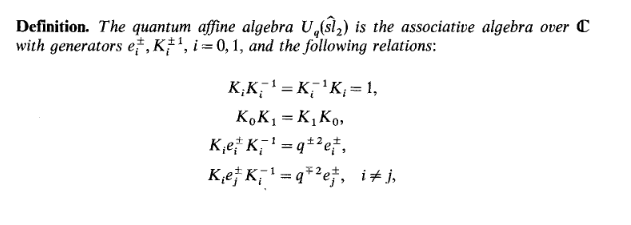
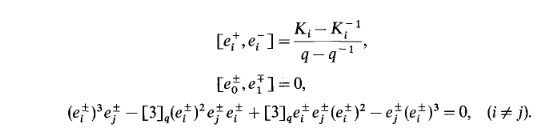

In [14]:

class AffineUrep:
    def __init__(self,dimension,E0,F0,K0,E1,F1,K1):
        self.dimension = dimension
        self.space = QQbar^dimension  # Vector space over complex numbers
        if E0.nrows() != self.dimension or E0.ncols() != self.dimension:
            raise ValueError(f"E0 must be {self.dimension}x{self.dimension}")
        if E1.nrows() != self.dimension or E1.ncols() != self.dimension:
            raise ValueError(f"E1 must be {self.dimension}x{self.dimension}")
        if F0.nrows() != self.dimension or F0.ncols() != self.dimension:
            raise ValueError(f"F0 must be {self.dimension}x{self.dimension}")
        if F1.nrows() != self.dimension or F1.ncols() != self.dimension:
            raise ValueError(f"F1 must be {self.dimension}x{self.dimension}")
        if K0.nrows() != self.dimension or K0.ncols() != self.dimension:
            raise ValueError(f"K0 must be {self.dimension}x{self.dimension}")
        if K1.nrows() != self.dimension or K1.ncols() != self.dimension:
            raise ValueError(f"E must be {self.dimension}x{self.dimension}")
        if not (K0.is_invertible()):
            raise ValueError("K0 is not invertible")
        if not (K1.is_invertible()):
            raise ValueError("K1 is not invertible")
        if not ((K0*K1-K1*K0).is_zero() and 
                (K1*E1*K1.inverse() - q^2*E1).is_zero() and 
                (K0*E0*K0.inverse() - q^2*E0).is_zero() and
                (K0*F0*K0.inverse() - q^(-2)*F0).is_zero() and 
                (K1*F1*K1.inverse() - q^(-2)*F1).is_zero() and 
                (K0*E1*K0.inverse() - q^(-2)*E1).is_zero() and 
                (K0*F1*K0.inverse() - q^(2)*F1).is_zero() and 
                (K1*E0*K1.inverse() - q^(-2)*E0).is_zero() and 
                (K1*F0*K1.inverse() - q^(2)*F0).is_zero() and 
                (E0*F0-F0*E0 - (K0-K0.inverse())/(q-q^(-1))).is_zero() and 
                (E1*F1-F1*E1 - (K1-K1.inverse())/(q-q^(-1))).is_zero() and 
                (E0*F1-F1*E0).is_zero() and 
                (F0*E1-E1*F0).is_zero() and 
                (E0^3*E1-(q^3-q^(-3))/(q-q^(-1))*E0^2*E1*E0 + (q^3-q^(-3))/(q-q^(-1))*E0*E1*E0^2 - E1*E0^3).is_zero() and
                (E1^3*E0-(q^3-q^(-3))/(q-q^(-1))*E1^2*E0*E1 + (q^3-q^(-3))/(q-q^(-1))*E1*E0*E1^2 - E0*E1^3).is_zero() and
                (F0^3*F1-(q^3-q^(-3))/(q-q^(-1))*F0^2*F1*F0 + (q^3-q^(-3))/(q-q^(-1))*F0*F1*F0^2 - F1*F0^3).is_zero() and
                (F1^3*F0-(q^3-q^(-3))/(q-q^(-1))*F1^2*F0*F1 + (q^3-q^(-3))/(q-q^(-1))*F1*F0*F1^2 - F0*F1^3).is_zero()
                ):
            print(K0*K1-K1*K0) 
            print(K0*F0*K0.inverse() - q^(-2)*F0)
            print(K1*E1*K1.inverse() - q^2*E1)
            print(K0*E0*K0.inverse() - q^2*E0)
            print(K1*F1*K1.inverse() - q^(-2)*F1)
            print(K0*E1*K0.inverse() - q^(-2)*E1)
            print(K0*F1*K0.inverse() - q^(2)*F1)
            print(K1*E0*K1.inverse() - q^(-2)*E0)
            print(K1*F0*K1.inverse() - q^(2)*F0)
            print(E0*F0-F0*E0 - (K0-K0.inverse())/(q-q^(-1)))
            print(E1*F1-F1*E1 - (K1-K1.inverse())/(q-q^(-1)))
            print(E0*F1-F1*E0)
            print(F0*E1-E1*F0)
            print(E0^3*E1-(q^3-q^(-3))/(q-q^(-1))*E0^2*E1*E0 + (q^3-q^(-3))/(q-q^(-1))*E0*E1*E0^2 - E1*E0^3)
            print(E1^3*E0-(q^3-q^(-3))/(q-q^(-1))*E1^2*E0*E1 + (q^3-q^(-3))/(q-q^(-1))*E1*E0*E1^2 - E0*E1^3)
            print(F0^3*F1-(q^3-q^(-3))/(q-q^(-1))*F0^2*F1*F0 + (q^3-q^(-3))/(q-q^(-1))*F0*F1*F0^2 - F1*F0^3)
            print(F1^3*F0-(q^3-q^(-3))/(q-q^(-1))*F1^2*F0*F1 + (q^3-q^(-3))/(q-q^(-1))*F1*F0*F1^2 - F0*F1^3)
            raise ValueError("The relations do not hold!")
        self.E0 = E0
        self.F0 = F0
        self.K0 = K0
        self.E1 = E1
        self.F1 = F1
        self.K1 = K1
        
    def E0_mult(self, vector):
        return self.E0 * vector
    def F0_mult(self, vector):
        return self.F0 * vector
    def K0_mult(self, vector):
        return self.K0 * vector
    def K0inv_mult(self, vector):
        return (self.K0).inverse() * vector
    def E1_mult(self, vector):
        return self.E1 * vector
    def F1_mult(self, vector):
        return self.F1 * vector
    def K1_mult(self, vector):
        return self.K1 * vector
    def K1inv_mult(self, vector):
        return (self.K1).inverse() * vector
        
    def basis_element(self, i):
        """Get the i-th standard basis element"""
        v = vector(QQ, [0]*self.dimension)
        v[i] = 1
        return v
    def print_matrices(self):
        print("This is a U-rep of dimension " + self.dimension.str() + ". E0,F0,K0,E1,F1,K1 act by ")
        print("E0:")
        print(self.E0)
        print("F0:")
        print(self.F0)
        print("K0:")
        print(self.K0)
        print("E1:")
        print(self.E1)
        print("F1:")
        print(self.F1)
        print("K1:")
        print(self.K1)
                    
def tensor_maps_of_AffineUreps(space1, space2):
    
    n1, n2 = space1.dimension, space2.dimension
    tensor_dimension = n1 * n2
    
    # Create basis labels for tensor product: (i,j) means e_i ⊗ f_j
    tensor_basis_labels = [(i, j) for i in range(n1) for j in range(n2)]
    
    # Initialize the matrices for E,F,K acting on the tensor product
    tensor_map_E0 = matrix(QQbar, tensor_dimension, tensor_dimension)
    tensor_map_F0 = matrix(QQbar, tensor_dimension, tensor_dimension)
    tensor_map_K0 = matrix(QQbar, tensor_dimension, tensor_dimension)
    # F0or each basis element e_i ⊗ f_j of the tensor product
    for col_idx, (i, j) in enumerate(tensor_basis_labels):
        # precompute all necessary actions on the base spaces
        E0_ei = space1.E0_mult(space1.basis_element(i))
        E0_fj = space2.E0_mult(space2.basis_element(j))
        F0_ei = space1.F0_mult(space1.basis_element(i))
        F0_fj = space2.F0_mult(space2.basis_element(j))
        K0_ei = space1.K0_mult(space1.basis_element(i))
        K0_fj = space2.K0_mult(space2.basis_element(j))
        K0inv_ei = space1.K0inv_mult(space1.basis_element(i))
        K0inv_fj = space2.K0inv_mult(space2.basis_element(j))
        # Compute K0(e_i ⊗ f_j) = K0(e_i) ⊗ K0(f_j)
        for k in range(n1):
            for l in range(n2):
                if K0_ei[k] != 0 and K0_fj[l] != 0:
                    row_idx = tensor_basis_labels.index((k, l))
                    tensor_map_K0[row_idx, col_idx] += K0_ei[k] * K0_fj[l]
        # Compute F0(e_i ⊗ f_j) = F0(e_i) ⊗ K0inv(f_j) + e_i ⊗ F0(f_j)
        # first term
        for k in range(n1):
            for l in range(n2):
                if F0_ei[k] != 0 and K0inv_fj[l] != 0:
                    row_idx = tensor_basis_labels.index((k, l))
                    tensor_map_F0[row_idx, col_idx] += F0_ei[k] * K0inv_fj[l]
        # second term
        for l in range(n2):
            if F0_fj[l] != 0:
                row_idx = tensor_basis_labels.index((i, l))
                # print(i,j,col_idx,k,l)
                tensor_map_F0[row_idx, col_idx] += F0_fj[l]
        # Compute E0(e_i ⊗ f_j) = K0(e_i) ⊗ E0(f_j) + E0(e_i) ⊗ 1(f_j)
        # first term
        for k in range(n1):
            for l in range(n2):
                if K0_ei[k] != 0 and E0_fj[l] != 0:
                    row_idx = tensor_basis_labels.index((k, l))
                    tensor_map_E0[row_idx, col_idx] += K0_ei[k] * E0_fj[l]
        # second term
        for k in range(n1):
            if E0_ei[k] != 0:
                row_idx = tensor_basis_labels.index((k,j))
                tensor_map_E0[row_idx, col_idx] += E0_ei[k]  
                
    tensor_map_E1 = matrix(QQbar, tensor_dimension, tensor_dimension)
    tensor_map_F1 = matrix(QQbar, tensor_dimension, tensor_dimension)
    tensor_map_K1 = matrix(QQbar, tensor_dimension, tensor_dimension)
    # F1or each basis element e_i ⊗ f_j of the tensor product
    for col_idx, (i, j) in enumerate(tensor_basis_labels):
        # precompute all necessary actions on the base spaces
        E1_ei = space1.E1_mult(space1.basis_element(i))
        E1_fj = space2.E1_mult(space2.basis_element(j))
        F1_ei = space1.F1_mult(space1.basis_element(i))
        F1_fj = space2.F1_mult(space2.basis_element(j))
        K1_ei = space1.K1_mult(space1.basis_element(i))
        K1_fj = space2.K1_mult(space2.basis_element(j))
        K1inv_ei = space1.K1inv_mult(space1.basis_element(i))
        K1inv_fj = space2.K1inv_mult(space2.basis_element(j))
        # Compute K1(e_i ⊗ f_j) = K1(e_i) ⊗ K1(f_j)
        for k in range(n1):
            for l in range(n2):
                if K1_ei[k] != 0 and K1_fj[l] != 0:
                    row_idx = tensor_basis_labels.index((k, l))
                    tensor_map_K1[row_idx, col_idx] += K1_ei[k] * K1_fj[l]
        # Compute F1(e_i ⊗ f_j) = F1(e_i) ⊗ K1inv(f_j) + e_i ⊗ F1(f_j)
        # first term
        for k in range(n1):
            for l in range(n2):
                if F1_ei[k] != 0 and K1inv_fj[l] != 0:
                    row_idx = tensor_basis_labels.index((k, l))
                    tensor_map_F1[row_idx, col_idx] += F1_ei[k] * K1inv_fj[l]
        # second term
        for l in range(n2):
            if F1_fj[l] != 0:
                row_idx = tensor_basis_labels.index((i, l))
                # print(i,j,col_idx,k,l)
                tensor_map_F1[row_idx, col_idx] += F1_fj[l]
        # Compute E1(e_i ⊗ f_j) = K1(e_i) ⊗ E1(f_j) + E1(e_i) ⊗ 1(f_j)
        # first term
        for k in range(n1):
            for l in range(n2):
                if K1_ei[k] != 0 and E1_fj[l] != 0:
                    row_idx = tensor_basis_labels.index((k, l))
                    tensor_map_E1[row_idx, col_idx] += K1_ei[k] * E1_fj[l]
        # second term
        for k in range(n1):
            if E1_ei[k] != 0:
                row_idx = tensor_basis_labels.index((k,j))
                tensor_map_E1[row_idx, col_idx] += E1_ei[k]
                
    return tensor_map_E0, tensor_map_F0, tensor_map_K0, tensor_map_E1, tensor_map_F1, tensor_map_K1

def tensor_product_of_AffineUreps(space1, space2):
    n1, n2 = space1.dimension, space2.dimension
    tensor_dimension = n1 * n2
    tensor_map_E0, tensor_map_F0, tensor_map_K0, tensor_map_E1, tensor_map_F1, tensor_map_K1 = tensor_maps_of_AffineUreps(space1,space2)
    result = AffineUrep(tensor_dimension, tensor_map_E0, tensor_map_F0, tensor_map_K0, tensor_map_E1, tensor_map_F1, tensor_map_K1)
    return result

We now do the exact same thing as we did before and check that the trivial representation behaves as it should.

In [15]:
E0triv = matrix(QQbar,1,1,0)
F0triv = matrix(QQbar,1,1,0)
K0triv = matrix(QQbar,1,1,0)
K0triv[0,0] = 1
E1triv = matrix(QQbar,1,1,0)
F1triv = matrix(QQbar,1,1,0)
K1triv = matrix(QQbar,1,1,0)
K1triv[0,0] = 1

trivial_AffineUrep = AffineUrep(1,E0triv,F0triv,K0triv,E1triv,F1triv,K1triv)
trivial_AffineUrep.print_matrices()
rep = tensor_product_of_AffineUreps(trivial_AffineUrep, trivial_AffineUrep)
print("TRIVIAL REP TENSOR TRIVIAL REP:")
rep.print_matrices()

This is a U-rep of dimension 1. E0,F0,K0,E1,F1,K1 act by 
E0:
[0]
F0:
[0]
K0:
[1]
E1:
[0]
F1:
[0]
K1:
[1]
TRIVIAL REP TENSOR TRIVIAL REP:
This is a U-rep of dimension 1. E0,F0,K0,E1,F1,K1 act by 
E0:
[0]
F0:
[0]
K0:
[1]
E1:
[0]
F1:
[0]
K1:
[1]


Let's try and define the evaluation representation and see it actually is a representation.

In [16]:
def eval_rep(n,a):
    if a == 0:
        raise ValueError("The evaluation rep needs a not equal to zero.")
    return AffineUrep(n+1,q^(-1)*a*matrix_F(n),q*a^(-1)*matrix_E(n),matrix_K(n).inverse(),matrix_E(n),matrix_F(n),matrix_K(n))

rep = eval_rep(3,2)
rep.print_matrices()

This is a U-rep of dimension 4. E0,F0,K0,E1,F1,K1 act by 
E0:
[0 0 0 0]
[1 0 0 0]
[0 1 0 0]
[0 0 1 0]
F0:
[   0 21/4    0    0]
[   0    0 25/4    0]
[   0    0    0 21/4]
[   0    0    0    0]
K0:
[1/8   0   0   0]
[  0 1/2   0   0]
[  0   0   2   0]
[  0   0   0   8]
E1:
[   0 21/4    0    0]
[   0    0 25/4    0]
[   0    0    0 21/4]
[   0    0    0    0]
F1:
[0 0 0 0]
[1 0 0 0]
[0 1 0 0]
[0 0 1 0]
K1:
[  8   0   0   0]
[  0   2   0   0]
[  0   0 1/2   0]
[  0   0   0 1/8]


We will try and test the theorem in the paper, which describes when tensor product of evaluation reps are irreducible and if not, what their proper subrepresentations look like.

In [17]:
def general_position(m,a,n,b):
    """
    Check if S_m(a) and S_n(b) are in general position as defined in Chari,Pressley (1991)
    """
    for p in range(1,min(a,b)+1):
        if (b/a == q^(m+n-2*p+2)) or (b/a == q^(-(m+n-2*p+2))):
            return false
    return true

# example of irreducibility
m = 1
a = 9
n = 2
b = 2
rep1 = eval_rep(m,a)
# rep1.print_matrices()
rep2 = eval_rep(n,b)
# rep2.print_matrices()
rep = tensor_product_of_AffineUreps(rep1, rep2)
rep.print_matrices()
generators = [rep.E0,rep.F0,rep.K0,rep.E1,rep.F1,rep.K1]
inv_subspace = find_invariant_subspace(generators)
print("Invariant subspaces found:")
print(inv_subspace)
print(f"Tensor product of S_{m}({a}) and S_{n}({b})")
print(f"Irreducible: {inv_subspace == []}")
print(f"In general position: {general_position(m,a,n,b)}")

This is a U-rep of dimension 6. E0,F0,K0,E1,F1,K1 act by 
E0:
[  0   0   0   0   0   0]
[1/2   0   0   0   0   0]
[  0 1/2   0   0   0   0]
[9/2   0   0   0   0   0]
[  0 9/2   0   2   0   0]
[  0   0 9/2   0   2   0]
F0:
[   0  5/2    0  8/9    0    0]
[   0    0  5/2    0  2/9    0]
[   0    0    0    0    0 1/18]
[   0    0    0    0  5/2    0]
[   0    0    0    0    0  5/2]
[   0    0    0    0    0    0]
K0:
[1/8   0   0   0   0   0]
[  0 1/2   0   0   0   0]
[  0   0   2   0   0   0]
[  0   0   0 1/2   0   0]
[  0   0   0   0   2   0]
[  0   0   0   0   0   8]
E1:
[  0   5   0   1   0   0]
[  0   0   5   0   1   0]
[  0   0   0   0   0   1]
[  0   0   0   0 5/4   0]
[  0   0   0   0   0 5/4]
[  0   0   0   0   0   0]
F1:
[  0   0   0   0   0   0]
[  1   0   0   0   0   0]
[  0   1   0   0   0   0]
[1/4   0   0   0   0   0]
[  0   1   0   1   0   0]
[  0   0   4   0   1   0]
K1:
[  8   0   0   0   0   0]
[  0   2   0   0   0   0]
[  0   0 1/2   0   0   0]
[  0   0   0   2   0   0

Here is another test where it turns out they are not irreducible.
In fact, we have $p=2,$ and the paper predicts the existence of a unique one-dimensional subrepresentation, which we can confirm:

In [21]:
m = 2
a = 8
n = 2
b = 2
rep1 = eval_rep(m,a)
# rep1.print_matrices()
rep2 = eval_rep(n,b)
# rep2.print_matrices()
rep = tensor_product_of_AffineUreps(rep1, rep2)
generators = [rep.E0,rep.F0,rep.K0,rep.E1,rep.F1,rep.K1]
inv_subspace = find_invariant_subspace(generators)
print(inv_subspace)
print(f"Tensor product of S_{m}({a}) and S_{n}({b})")
print(f"Irreducible: {inv_subspace == []}")
print(f"In general position: {general_position(m,a,n,b)}")

[(0, 0, 1, 0, -4, 0, 4, 0, 0)]
Tensor product of S_2(8) and S_2(2)
Irreducible: False
In general position: False


Let us study a three-fold tensor product and see what subrepresentations it will have in case of it not being irreducible.

In [20]:
rep1 = eval_rep(1,1)
rep2 = eval_rep(1,4)
rep3 = eval_rep(1,16)
twofold_tp = tensor_product_of_AffineUreps(rep1, rep2)
threefold_tp = tensor_product_of_AffineUreps(twofold_tp, rep3)
threefold_tp.print_matrices()
generators = [threefold_tp.E0,threefold_tp.F0,threefold_tp.K0,threefold_tp.E1,threefold_tp.F1,threefold_tp.K1]
inv_subspace = find_invariant_subspace(generators)
print(inv_subspace)

This is a U-rep of dimension 8. E0,F0,K0,E1,F1,K1 act by 
E0:
[  0   0   0   0   0   0   0   0]
[  2   0   0   0   0   0   0   0]
[  1   0   0   0   0   0   0   0]
[  0   1   8   0   0   0   0   0]
[1/2   0   0   0   0   0   0   0]
[  0 1/2   0   0   8   0   0   0]
[  0   0 1/2   0   4   0   0   0]
[  0   0   0 1/2   0   4  32   0]
F0:
[  0 1/8   1   0   8   0   0   0]
[  0   0   0 1/4   0   2   0   0]
[  0   0   0 1/8   0   0   2   0]
[  0   0   0   0   0   0   0 1/2]
[  0   0   0   0   0 1/8   1   0]
[  0   0   0   0   0   0   0 1/4]
[  0   0   0   0   0   0   0 1/8]
[  0   0   0   0   0   0   0   0]
K0:
[1/8   0   0   0   0   0   0   0]
[  0 1/2   0   0   0   0   0   0]
[  0   0 1/2   0   0   0   0   0]
[  0   0   0   2   0   0   0   0]
[  0   0   0   0 1/2   0   0   0]
[  0   0   0   0   0   2   0   0]
[  0   0   0   0   0   0   2   0]
[  0   0   0   0   0   0   0   8]
E1:
[  0   4   2   0   1   0   0   0]
[  0   0   0   2   0   1   0   0]
[  0   0   0   1   0   0   1   0]
[  0   0

There is one 4-dimensional subrep.